In [112]:
# !pip install -q supervision jupyter_bbox_widget
# !pip install torch torchvision numpy matplotlib opencv-python
# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

In [152]:
import cv2
import base64
import find_edges
import G_Code_Generation
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import importlib
importlib.reload(find_edges)
importlib.reload(G_Code_Generation)

IMAGE_PATH = "/content/drive/MyDrive/Guidance/SAM2_Gcode/sample_image/lab_glassware_1.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [153]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

def show_mask(mask, ax, random_color=False, borders = True):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [154]:
sam2_checkpoint = "/content/drive/MyDrive/Guidance/SAM2_Gcode/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image_rgb)

In [155]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=['0','1'])
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(classes=['0', '1'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e37…

In [159]:
boxes = widget.bboxes
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes ])

input_label = np.array([ int(box['label']) for box in boxes ])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

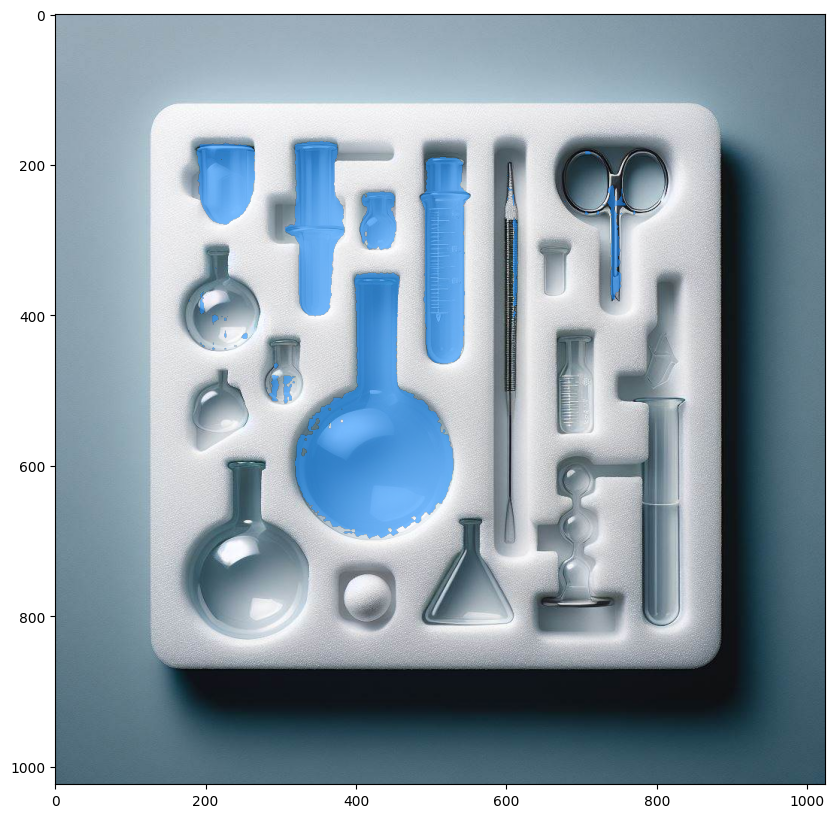

In [160]:
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_mask(masks, plt.gca(), random_color=True)

In [141]:
smooth_mask,approx_contours,output = find_edges.image_processing().get_contours(masks)
G_Code_Generation.GCodeGenerator().generate_from_contours(approx_contours)